In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.special import gamma, beta ,gammainc, gammaincinv
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
import os

# Model

In [3]:
# ---------------------- Global Parameters ---------------------- #
njobsim = 5000000      # Total number of jobs to simulate for statistical stability
ES = 1.0               # Target Mean Service Time (E[S])
COV = 1.00001          # Target Coefficient of Variation (std_dev / mean)
rho = 0.8              # Traffic intensity / System load (arrival_rate * mean_service_time)

# ---------------------- Parameter Computation ---------------------- #
# This section uses a bisection method (binary search) to find the 
# distribution parameters required to achieve the desired COV.
d = (1 + COV**2) / 2.0
tol = 1e-6             # Convergence tolerance
error = 1.0
xsup = 1.0             # Upper bound for search
xinf = 0.0             # Lower bound for search

while error > tol:
    x = (xsup + xinf) / 2.0
    # y represents the theoretical relationship between shape parameters and COV
    y = x / beta(1/x, 1/x) 
    if y > d:
        xinf = x
    else:
        xsup = x
    error = (xsup - xinf) / ((xsup + xinf) / 2.0)

b = x                  # Calculated shape parameter
a = b / gamma(1/b)     # Scale parameter normalization

# Compute arrival rate based on desired system load (rho)
lambda_val = rho / ES
# Second moment of service time (useful for theoretical queue length checks)
ES2 = (ES**2) * (1 + COV**2)

# ---------------------- Simulation Execution ---------------------- #
N = 2                  # Scaling factor or number of servers/stages
mu = 1.0 / N

# Generate Inter-arrival Times (Exponential distribution)
Tv = -np.log(np.random.rand(njobsim)) / lambda_val
# Generate Arrival Timestamps
Av = np.cumsum(Tv)

# Generate Service Times (Sv) using the Inverse Transform method
# v represents the underlying uniform random variable
v = np.maximum(1e-20, np.abs(-np.log(np.random.rand(njobsim))))
Sv = a * (v ** (1.0 / b))  # Transforming to the target distribution
Xv = Sv / mu               # Normalized or scaled service times

# ---------------------- Validation ---------------------- #
# Verify if the generated samples match the requested COV
print('Real COV:', np.sqrt(np.var(Sv)) / np.mean(Sv))

Real COV: 0.9997761257508171


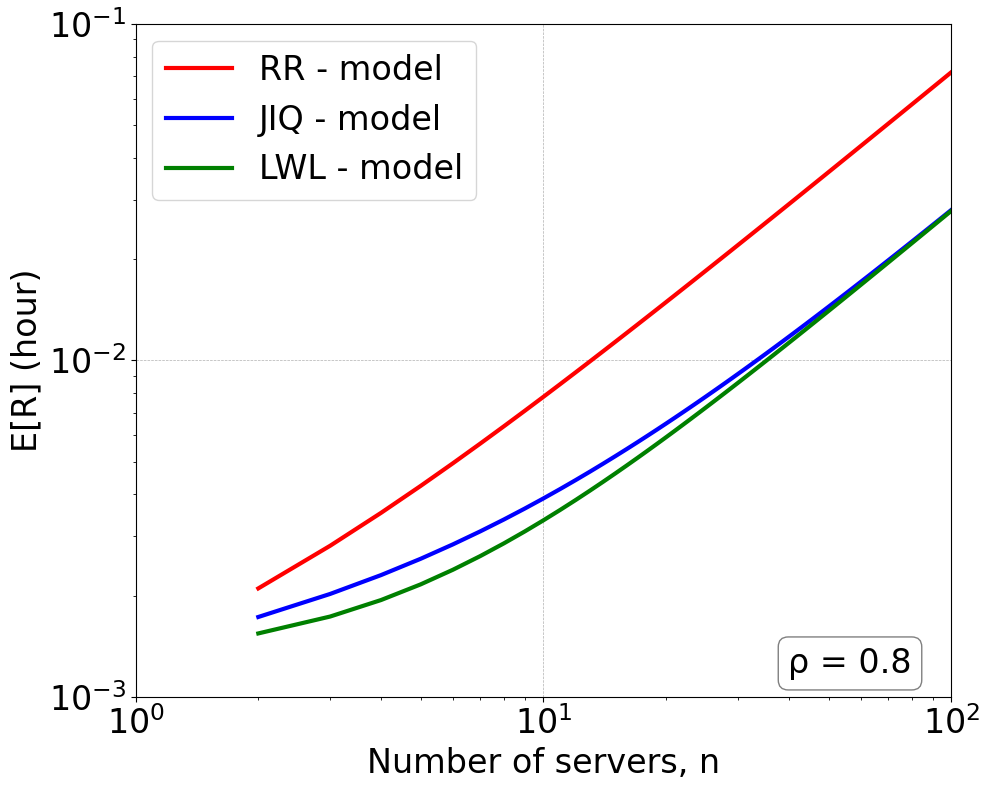

In [6]:
# ---------------------- Data Preparation & Filtering ---------------------- #
# In this block, we prepare the arrival and service time vectors.
AJv = Av          # Arrival times
CJv = Sv          # Service times (duration)
Cv = Sv

AJallv = AJv
CJallv = CJv
njob = len(AJv)

# Percentile-based filtering (Currently set to 1.0, meaning no data is cut)
xv = np.sort(CJallv)
cutquant = 1 
th = xv[int(np.ceil(cutquant * len(xv))) - 1]
jv = CJallv <= th
AJrv = AJallv[jv]
CJrv = CJallv[jv]
njobr = len(jv)

# ---------------------- System Parameter Extraction ---------------------- #
# Compute statistical moments from the generated trace
Timehorizon = AJrv[-1] - AJrv[0]
IATv = np.diff(AJrv)                 # Inter-arrival times
lambda_ = 1 / np.mean(IATv)          # Aggregate arrival rate
CA = np.std(IATv) / np.mean(IATv)    # Coeff. of Variation of arrivals
EC = np.mean(CJrv)                   # Mean service requirement
CX = np.std(CJrv) / EC               # Coeff. of Variation of service times

# Fixed target system-wide utilization
rho0 = 0.8 
# Total processing capacity required to maintain rho0
mutot = np.sum(CJrv) / Timehorizon / rho0

# ---------------------- Performance Modeling (Scaling N) ---------------------- #
Nmin, Nmax = 2, 100
Nv = np.arange(Nmin, Nmax + 1)

ERsinglestageRRv = []
ERsinglestageLWLv = []
ERsinglestageJIQv = []

for N in Nv:
    # Scale individual server capacity and local arrival rate
    mu = mutot / N
    lambda1 = lambda_ / N
    CA1 = CA / np.sqrt(N)            # Arrival smoothing effect
    EX1 = EC / mu
    CX1 = CX
    rho1 = lambda1 * EX1             # Local load (should equal rho0)

    # --- 1. Round Robin (RR) Model ---
    # Kingman-like approximation for G/G/1 queue response time
    scalef1 = (1 + CX1**2) * (CA1**2 + (rho1 * CX1)**2) / (1 + (rho1 * CX1)**2) / 2
    ERsinglestageRR = EX1 + EX1 * (rho1 / (1 - rho1)) * scalef1
    ERsinglestageRRv.append(ERsinglestageRR)

    # --- 2. Least-Work-Left (LWL) Model ---
    # Approaches M/G/N performance; uses Erlang-C (B) and scaling factors
    EX = EC / mu
    A = N * rho1                     # Offered load
    B = 1                            # Iterative calculation of Erlang-B
    for hhh in range(1, N + 1):
        B = A * B / (hhh + A * B)
    
    # Probability of queuing (C) derived from Erlang-B
    C = B / (1 - rho0 + rho0 * B)
    scalef = (1 + CX**2) * (CA**2 + (rho0 * CX)**2) / (1 + (rho0 * CX)**2) / 2
    ERsinglestageLWL = EX + EX * (C / (N * (1 - rho0))) * scalef
    ERsinglestageLWLv.append(ERsinglestageLWL)

    # --- 3. Join-Idle-Queue (JIQ) Model ---
    # Modeled as a mixture of the idle-server benefit (LWL) and random routing (RR)
    ERsinglestageJIQ = (1 - B) * ERsinglestageLWL + B * ERsinglestageRR
    ERsinglestageJIQv.append(ERsinglestageJIQ)

# ---------------------- Visualization ---------------------- #
sechour = 3600  # Conversion factor (seconds to hours)
y1v = np.array(ERsinglestageRRv) / sechour
y2v = np.array(ERsinglestageJIQv) / sechour
y3v = np.array(ERsinglestageLWLv) / sechour

plt.figure(figsize=(10, 8))
plt.loglog(Nv, y1v, 'r-', linewidth=3.0, label="RR - model")
plt.loglog(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - model")
plt.loglog(Nv, y3v, 'g-', linewidth=3.0, label="LWL - model")

plt.xlabel('Number of servers, n', fontsize=24)
plt.ylabel('E[R] (hour)', fontsize=24)
plt.legend(loc="upper left", fontsize=24)

plt.grid(True, which="major", linestyle='--', linewidth=0.5)
plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(y3v))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)

# Positioning the rho label box
plt.text(
    0.80 * max(Nv), 0.65 * min(y2v),  
    f"ρ = {rho0}",
    fontsize=24,
    ha='right',  
    va='bottom',  
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
)

plt.tight_layout()
plt.show()

# Simulations

In [ ]:
def RR_FCFS_calc_ER(Nse):
    """
    Simulates a Round-Robin dispatching system with Nse servers.
    Calculates the Mean Response Time (ER) based on job arrival and service times.
    """
    # Total simulation duration
    Timehorizon = Av[-1] - Av[0]
    
    # Calculate service rate (mu) to ensure the system maintains the target 'rho'
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu  # Scaled service times
    Jv = jobIDppv # Job IDs (tracks tasks belonging to the same job)

    tnow = 0.0
    Uv = np.zeros(Nse)                 # Current workload (remaining work) per server
    joblistv = np.unique(Jv)
    
    # Arrays to track the lifecycle of each unique job
    tstartjobv = np.full(len(joblistv), np.inf)
    tendjobv = np.zeros(len(joblistv))
    
    # Mapping Job IDs to indices for faster lookup
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]  # Arrival time of current task
        X = Xv[ii]  # Service time of current task

        # --- Workload Evolution ---
        # Update workload on all servers based on time elapsed since last arrival
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # --- Dispatching Logic ---
        # Round-Robin: tasks are assigned sequentially (0, 1, 2, ..., Nse-1, 0, ...)
        jsel = ii % Nse

        # Add current task's work to the selected server's queue
        Uv[jsel] += X

        # --- Statistics Tracking ---
        # Update the start and finish times for the overall job
        jidx = job_index[Jv[ii]]
        
        # Record the arrival of the first task of this job
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
            
        # The job's completion is defined by the latest finishing task
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    # Calculate Mean Response Time across all jobs
    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob

In [ ]:
def JIQ_FCFS_calc_ER(Nse):
    """
    Simulates Join-Idle-Queue (JIQ) dispatching with Nse servers.
    Prioritizes idle servers; if all are busy, dispatches randomly.
    """
    rho = 0.8
    Timehorizon = Av[-1] - Av[0]
    
    # Normalizing service rate to maintain target system load
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu  # Scaled task service times
    Jv = jobIDppv # Job ID mapping for multi-task jobs

    tnow = 0.0
    Uv = np.zeros(Nse)                 # Current workload per server
    joblistv = np.unique(Jv)
    njob = len(joblistv)
    
    tstartjobv = np.full(njob, np.inf)
    tendjobv = np.zeros(njob)

    # Map Job IDs to indices for O(1) tracking performance
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]  # Arrival time
        X = Xv[ii]  # Service time requirement

        # --- Workload Decay ---
        # Reduce the remaining work on all servers by the time elapsed
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # --- JIQ Dispatching Logic ---
        # 1. Check if there are any idle servers (workload == 0)
        if np.min(Uv) > 0.0:
            # All servers are busy: pick one at random
            jsel = np.random.randint(Nse)
        else:
            # Identify all currently idle servers
            idle = np.where(Uv == 0.0)[0]
            # Randomly select one server from the idle pool
            jsel = idle[np.random.randint(len(idle))]

        # --- Update System State ---
        Uv[jsel] += X

        # --- Statistics Tracking ---
        jidx = job_index[Jv[ii]]
        
        # Capture the very first arrival time of the job
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
            
        # Capture the latest completion time across all tasks in the job
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    # Calculate Mean Response Time across all jobs
    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob

In [ ]:
def LWL_FCFS_calc_ER(Nse):
    """
    Simulates Least-Work-Left (LWL) dispatching with Nse servers.
    Dispatches each task to the server with the smallest current backlog.
    """
    Timehorizon = Av[-1] - Av[0]
    
    # Calculate service rate to maintain system-wide target load (rho)
    mu = np.sum(Cv) / Timehorizon / Nse / rho
    Xv = Cv / mu  # Task service times
    Jv = jobIDppv # Job ID mapping

    tnow = 0.0
    Uv = np.zeros(Nse)                 # Workload (remaining time) per server
    joblistv = np.unique(Jv)
    
    # Track the lifespan of each unique job
    tstartjobv = np.full(len(joblistv), np.inf)
    tendjobv = np.zeros(len(joblistv))
    
    # Index mapping for efficient updates
    job_index = {jid: i for i, jid in enumerate(joblistv)}

    for ii in range(len(Av)):
        A = Av[ii]  # Arrival time
        X = Xv[ii]  # Work requirement

        # --- Workload Processing ---
        # Update server backlogs based on elapsed time since the last event
        elapsed = A - tnow
        tnow = A
        Uv = np.maximum(0.0, Uv - elapsed)

        # --- LWL Dispatching Logic ---
        # Find the server(s) with the minimum work left
        Umin = np.min(Uv)
        cand = np.where(Uv == Umin)[0]
        
        # Tie-break: if multiple servers have the same minimum work, pick one randomly
        jsel = cand[np.random.randint(len(cand))]

        # --- Enqueue and Update Stats ---
        Uv[jsel] += X

        # Update the start/end window for the specific job this task belongs to
        jidx = job_index[Jv[ii]]
        if A < tstartjobv[jidx]:
            tstartjobv[jidx] = A
            
        # The task finishes after its assigned server clears current backlog + task work
        finish = A + Uv[jsel]
        if finish > tendjobv[jidx]:
            tendjobv[jidx] = finish

    # Calculate global Mean Response Time
    ERjob = np.mean(tendjobv - tstartjobv)
    return ERjob

In [ ]:
# ---------------------- Parallel Simulation Execution ---------------------- #
# Assumes Av, Cv, rho, and the three calculation functions are defined.

# Reset job IDs if necessary (assigning each task a unique job ID)
jobIDppv = np.arange(1, len(Av) + 1)

# Define the server scaling range for the simulation
Nses = [2, 3, 4, 6, 8, 10, 20, 30, 40, 50, 100]

def _run_nse(n):
    """
    Worker function to execute all three policies for a given server count 'n'.
    This is defined at the top level to allow for process pickling.
    """
    return {
        "Nse": n,
        "RR_ER":  RR_FCFS_calc_ER(n),
        "JIQ_ER": JIQ_FCFS_calc_ER(n),
        "LWL_ER": LWL_FCFS_calc_ER(n),
    }

if __name__ == "__main__":
    # Determine number of workers based on available CPU cores
    workers = min(len(Nses), os.cpu_count() or 1)
    
    print(f"Starting simulation on {workers} cores...")
    
    # Run simulations in parallel
    with ProcessPoolExecutor(max_workers=workers) as exe:
        results = list(exe.map(_run_nse, Nses))

    # Compile results into a structured DataFrame for analysis
    df_results = (
        pd.DataFrame(results)
        .sort_values("Nse")
        .reset_index(drop=True)
    )

# Display the resulting data table
df_results

,Nse,RR_ER,JIQ_ER,LWL_ER
0,2,7.675228,6.902369,5.545907
1,3,10.367177,8.218596,6.227791
2,4,13.064301,9.304242,6.973407
3,6,18.404907,11.235068,8.578991
4,8,23.765115,13.034300,10.276878
5,10,29.133155,14.802104,12.032198
6,20,56.007682,23.671264,21.262314
7,30,82.942094,32.825900,30.839968
8,40,110.197884,42.196204,40.580878
9,50,137.135295,51.719675,50.408108


# Plot Model-Simulations

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


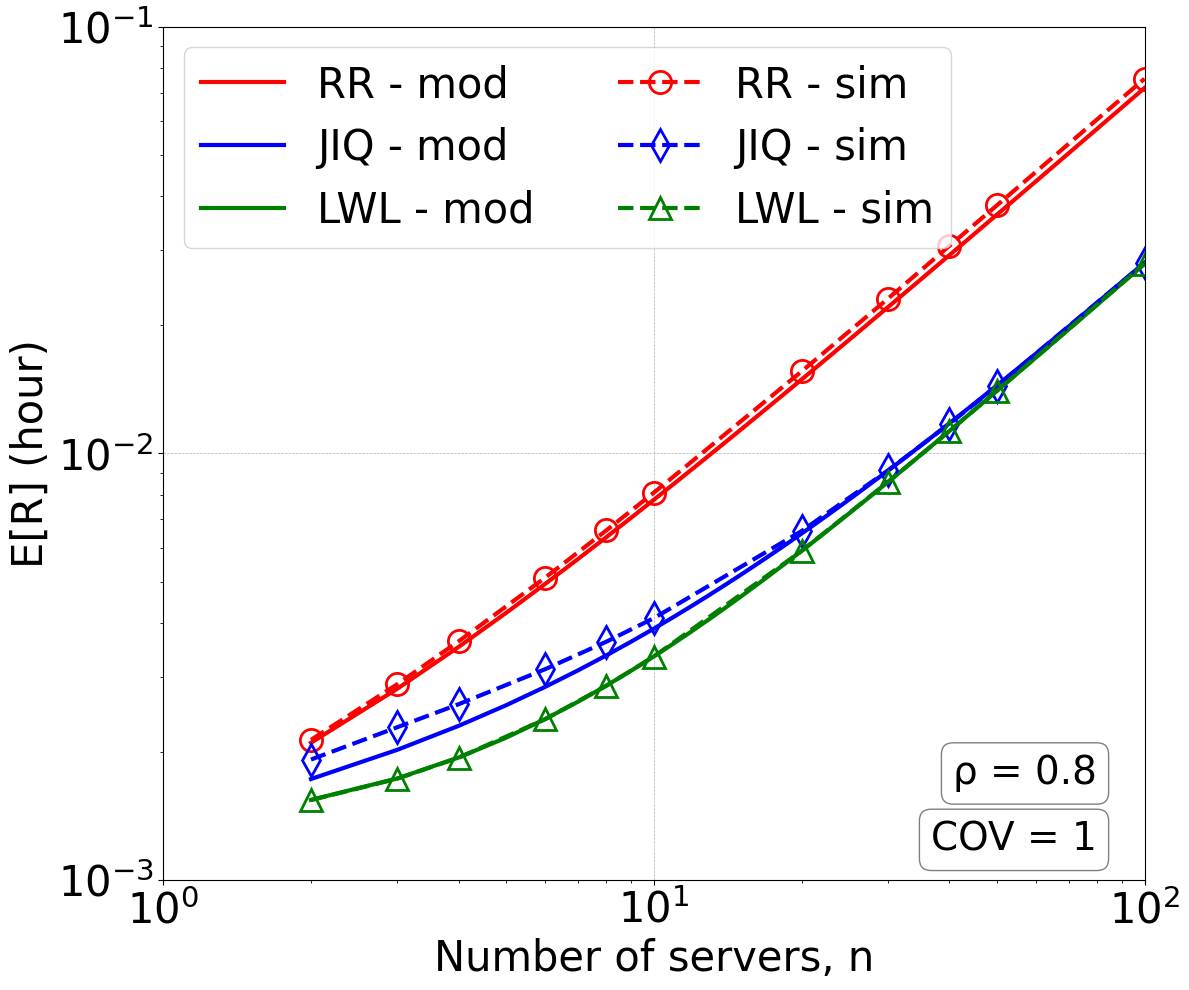

In [ ]:
sechour = 3600
y1v = np.array(ERsinglestageRRv)/ sechour
y2v = np.array(ERsinglestageJIQv) / sechour
y3v = np.array(ERsinglestageLWLv) / sechour
y4v = df_results["RR_ER"].values / sechour
y5v = df_results["JIQ_ER"].values / sechour
y6v = df_results["LWL_ER"].values / sechour

plt.figure(figsize=(12, 10))
plt.plot(Nv, y1v, 'r-', linewidth=3.0, label="RR - mod")
plt.plot(Nv, y2v, 'b-', linewidth=3.0, label="JIQ - mod")
plt.plot(Nv, y3v, 'g-', linewidth=3.0, label="LWL - mod")


plt.plot(Nses, y4v, 'r--o', linewidth=3, markersize=16, 
          markerfacecolor='none', markeredgewidth=2, label='RR - sim')
plt.plot(Nses, y5v, 'b--d', linewidth=3, markersize=16, 
          markerfacecolor='none', markeredgewidth=2, label='JIQ - sim')
plt.plot(Nses, y6v, 'g--^', linewidth=3, markersize=16, 
          markerfacecolor='none', markeredgewidth=2, label='LWL - sim') 


plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of servers, n', fontsize=30)
plt.ylabel('E[R] (hour)', fontsize=30)
plt.legend(loc="upper left", fontsize=30, ncol=2)

plt.grid(True, which="major", linestyle='--', linewidth=0.5)
plt.xlim(1, max(Nv))
plt.ylim(10**np.floor(np.log10(min(y3v))), 10**np.ceil(np.log10(max(y1v))))

plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

plt.text(
    0.80 * max(Nv), 0.93 * min(y2v),  # Adjust x and y coordinates
    f"ρ = {rho0}",
    fontsize=28,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)

plt.text(
    0.80 * max(Nv), 0.65 * min(y2v),  # Adjust x and y coordinates
    f"COV = {1}",
    fontsize=28,
    ha='right',  # Horizontal alignment
    va='bottom',  # Vertical alignment
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')  # Box style

)
plt.tight_layout()
plt.savefig(f'Outputs/Weibull_Model_Validation_COV{int(COV)}.eps', dpi=300, format='eps')
plt.show()